In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import skew,boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [35]:
train_features = pd.read_csv('lish-moa/train_features.csv')
train_targets = pd.read_csv('lish-moa/train_targets_scored.csv')
train_features = train_features.drop('sig_id',axis=1)
train_targets = train_targets.drop('sig_id',axis=1)

In [36]:

train_features, test_features, train_scored, test_scored = train_test_split(train_features, train_targets, test_size=0.5, random_state=42)


In [37]:
train_features = train_features.reset_index(drop=True)
train_targets = train_targets.reset_index(drop=True)
train_scored = train_scored.reset_index(drop=True)
test_scored = test_scored.reset_index(drop = True)

In [38]:
train_features = train_features[:5000]
test_features = test_features[:5000]
train_scored = train_scored[:5000]
test_scored = test_scored[:5000]

In [58]:
test_features.shape

(5000, 875)

In [39]:
def oneHotEncoding(data):
    # performing one hot encoding on discrete features
    discrete_features = ['cp_dose','cp_time','cp_type']
    data = pd.get_dummies(data,columns=discrete_features,dtype=int)
    return data 

In [40]:
def cross_entropy(predicted_probabilities,true_labels):
    # Compute cross-entropy loss
    epsilon = 1e-15  # A small constant to prevent numerical instability (avoid log(0))
    predicted_probabilities = np.clip(predicted_probabilities, epsilon, 1 - epsilon)  # Clip probabilities
    cross_entropy_loss = -np.mean(true_labels * np.log(predicted_probabilities) + (1 - true_labels) * np.log(1 - predicted_probabilities))
    return cross_entropy_loss

In [53]:
kfold = 3

# Initialize a KFold object
kf = KFold(n_splits=kfold, shuffle=True, random_state=42)



min_sample_split = [0.2,0.4,0.6,0.8]


n_estimators = [10,30,50,70,100]

max_depth = [2,4,6,10]

# Initialize a list to store the cross-validation accuracies


# Perform k-fold cross-validation with PCA
itr = 0

pc = [4,10,15,40,60,80]

neighbour = [5,10,25,50,100,200,300]
avg_training = []
avg_validation = []

for i in range(len(max_depth)):
    cross_val_scores = [] 
    train_cross_val_score = []
    for train_index, test_index in kf.split(train_features):


        clf = RandomForestClassifier(criterion='entropy',n_estimators = 80,min_samples_split=0.6 , max_depth= None)
        # ,max_features=max_feature[i]


        # Split the data into training and testing sets for this fold
        # X_train, X_test = train_features.iloc[train_index], train_features.iloc[test_index]
        # y_train, y_test = train_scored.iloc[train_index], train_scored.iloc[test_index]

        X_train, X_test = train_features.iloc[train_index], train_features.iloc[test_index]
        y_train, y_test = train_scored.iloc[train_index], train_scored.iloc[test_index]

        
        X_train = oneHotEncoding(X_train)
        X_test = oneHotEncoding(X_test)
        
        # lof_model = LocalOutlierFactor(n_neighbors=neighbour[itr], contamination=0.01)


        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # Initialize a PCA object (you can adjust the number of components)
        pca = PCA(n_components=10)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test  = pca.transform(X_test)

        test_columns = y_train.columns
        loss = 0
        loss_train = 0
        for col in test_columns:
            if (y_train[col].unique().shape[0]==1):
                y_pred = [0.001 for x in range(len(X_test))]
                y_train_pred = [0.001 for x in range(len(X_train))]
            # Train a classifier on the transformed training data
            else:
                clf.fit(X_train, y_train[col])
            
                y_train_pred = clf.predict_proba(X_train)
                y_train_pred = [row[1] for row in y_train_pred]
                # Make predictions on the transformed test data
                y_pred = clf.predict_proba(X_test)

                # print(y_pred)
                y_pred = [row[1] for row in y_pred]
                
                # print(y_pred)
                # print(y_train_pred)
            
            loss += cross_entropy(y_pred,y_test[col].values)

            loss_train += cross_entropy(y_train_pred,y_train[col].values)
        cross_val_scores.append(loss/test_columns.shape[0])
        train_cross_val_score.append(loss_train/test_columns.shape[0])

    itr += 1
    print(f"---------------------------------------{itr}----------------------------------------")
    # Calculate the mean and standard deviation of cross-validation scores
    print(f"cross validation score for training : {train_cross_val_score}")
    print(f"cross validation scores : {cross_val_scores}")
    mean_accuracy = np.mean(cross_val_scores)
    std_accuracy = np.std(cross_val_scores)
    print(f"mean loss : {mean_accuracy}")
    print(f"std dev of loss : {std_accuracy}")
    print("---------------------------------------------------------------------------------")


    avg_training.append(np.mean(train_cross_val_score))
    avg_validation.append(np.mean(cross_val_scores))


---------------------------------------1----------------------------------------
cross validation score for training : [0.01803911377735376, 0.01800293621369179, 0.017538347658778007]
cross validation scores : [0.019633063378608432, 0.01962656187311918, 0.020489298142606232]
mean loss : 0.01991630779811128
std dev of loss : 0.000405174051947011
---------------------------------------------------------------------------------
---------------------------------------2----------------------------------------
cross validation score for training : [0.01799553111739178, 0.01795184819434319, 0.017504073895366356]
cross validation scores : [0.019592580206358037, 0.01961257001425992, 0.02032696749994383]
mean loss : 0.019844039240187263
std dev of loss : 0.0003415793476959826
---------------------------------------------------------------------------------
---------------------------------------3----------------------------------------
cross validation score for training : [0.017994430416274267,

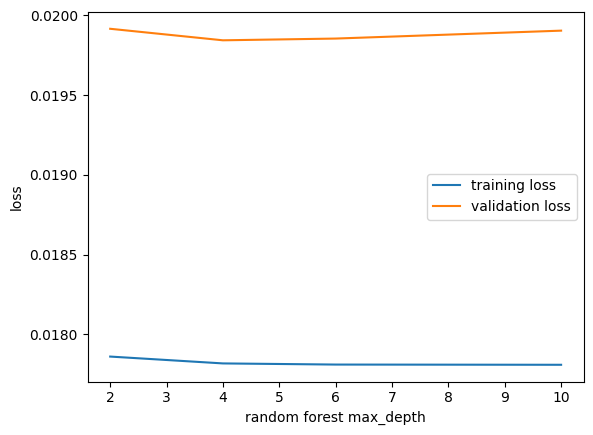

In [54]:
plt.plot(max_depth,avg_training,label = 'training loss')
plt.plot(max_depth,avg_validation,label = 'validation loss')
plt.xlabel('random forest max_depth')
plt.ylabel('loss')
plt.legend()
plt.show()

In [57]:
# clf = LogisticRegression(penalty = 'l1', C = 0.5, max_iter=10000,solver='liblinear')
clf = RandomForestClassifier(criterion='entropy',n_estimators = 80,min_samples_split=0.6 , max_depth= None)
# ,max_features=max_feature[i]


# Split the data into training and testing sets for this fold
# X_train, X_test = train_features.iloc[train_index], train_features.iloc[test_index]
# y_train, y_test = train_scored.iloc[train_index], train_scored.iloc[test_index]

X_train = train_features
y_train = train_scored

X_test = test_features
y_test = test_scored


X_train = oneHotEncoding(X_train)
X_test = oneHotEncoding(X_test)

# lof_model = LocalOutlierFactor(n_neighbors=neighbour[itr], contamination=0.01)

# # Fit the model and identify outliers
# outlier_scores = lof_model.fit_predict(X_train)
# outlier_indices = X_train.index[outlier_scores == -1]

# X_train = X_train.drop(outlier_indices)
# y_train  = y_train.drop(outlier_indices)

# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Initialize a PCA object (you can adjust the number of components)
pca = PCA(n_components=10)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test  = pca.transform(X_test)

test_columns = y_train.columns
loss = 0
loss_train = 0
for col in test_columns:
    if (y_train[col].unique().shape[0]==1):
        y_pred = [0.001 for x in range(len(X_test))]
        y_train_pred = [0.001 for x in range(len(X_train))]
    # Train a classifier on the transformed training data
    else:
        clf.fit(X_train, y_train[col])
    
        y_train_pred = clf.predict_proba(X_train)
        y_train_pred = [row[1] for row in y_train_pred]
        # Make predictions on the transformed test data
        y_pred = clf.predict_proba(X_test)

        # print(y_pred)
        y_pred = [row[1] for row in y_pred]
        
        # print(y_pred)
        # print(y_train_pred)
    
    loss += cross_entropy(y_pred,y_test[col].values)

    loss_train += cross_entropy(y_train_pred,y_train[col].values)

print(f"training loss : {loss_train/test_columns.shape[0]}")
print(f"The testing loss : {loss/test_columns.shape[0]}")

training loss : 0.01814324712445375
The testing loss : 0.01983983896040321
